Christos Christidis

We'll use the pre-trained BERT For Sequence Classification model to perform the binary classification task of sentiment analysis based on the Amazon Reviews for Senti-Analysis Binary -N/P+ dataset.

The original dataset can be found here  https://www.kaggle.com/datasets/yacharki/amazon-reviews-for-sa-binary-negative-positive-csv but I have modified it slightly for easier use.

* Import the necessary libraries
* Fetch and load the data
* Tokenize the reviews using BERT's own embedding
* Build Vocabularies
* Fetch and load the pre-trained model
* Freeze its pre-trained state and perform training only on the classifier layer

# Imports

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import time

In [144]:
#%pip install torch-summary

In [145]:
import torchtext
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

In [146]:
# %pip install transformers

In [147]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [148]:
# Run the following to solve the warning above
# %pip install ipywidgets --user

In [149]:
import spacy

In [111]:
print(torch.__version__)
torch.backends.cudnn.deterministic = True
print(torchtext.__version__)

2.3.0+cu121


# Settings

In [114]:
parameters = {
    "seq_length" : 128,
    "batch_size" : 32,
    "random_state" : 1000,
    "num_classes" : 2,
    "epochs" : 7, #3,
    "learning_rate" : 0.005,
    "device" :  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

In [60]:
parameters['device']

device(type='cuda')

# Preparing Data

In [21]:
df_train = pd.read_csv('amazon_train.csv')
df_test = pd.read_csv('amazon_test.csv')

In [22]:
df_train.head()

,review,sentiment
0,This sound track was beautiful! It paints the ...,1
1,I'm reading a lot of reviews saying that this ...,1
2,This soundtrack is my favorite music of all ti...,1
3,I truly like this soundtrack and I enjoy video...,1
4,"If you've played the game, you know how divine...",1


In [23]:
df_test.head()

,review,sentiment
0,My lovely Pat has one of the GREAT voices of h...,1
1,Despite the fact that I have only played a sma...,1
2,I bought this charger in Jul 2003 and it worke...,0
3,Check out Maha Energy's website. Their Powerex...,1
4,Reviewed quite a bit of the combo players and ...,1


In [26]:
X_train = df_train['review']
y_train = df_train['sentiment']
X_test = df_test['review']
y_test = df_test['sentiment']

In [74]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenizing train and test reviews
tokenized_train = [tokenizer.encode(review, max_length=parameters['seq_length'], truncation=True) for review in X_train]#, return_attention_mask=True) for review in X_train], use encode_plus for this
tokenized_test = [tokenizer.encode(review, max_length=parameters['seq_length'], truncation=True)  for review in X_test]#, return_attention_mask=True) for review in X_test]

tokenized_train

[[101,
  2023,
  2614,
  2650,
  2001,
  3376,
  999,
  2009,
  23262,
  1996,
  12411,
  7301,
  1999,
  2115,
  2568,
  2061,
  2092,
  1045,
  2052,
  28667,
  8462,
  4859,
  2009,
  2130,
  2000,
  2111,
  2040,
  5223,
  6819,
  2094,
  1012,
  2208,
  2189,
  999,
  1045,
  2031,
  2209,
  1996,
  2208,
  10381,
  4948,
  2080,
  2892,
  2021,
  2041,
  1997,
  2035,
  1997,
  1996,
  2399,
  1045,
  2031,
  2412,
  2209,
  2009,
  2038,
  1996,
  2190,
  2189,
  999,
  2009,
  10457,
  2185,
  2013,
  13587,
  9019,
  2075,
  1998,
  3138,
  1037,
  4840,
  2121,
  3357,
  2007,
  24665,
  3686,
  7334,
  1998,
  3969,
  3993,
  19505,
  1012,
  2009,
  2052,
  17894,
  3087,
  2040,
  14977,
  2000,
  4952,
  999,
  1034,
  1035,
  1034,
  102],
 [101,
  1045,
  1005,
  1049,
  3752,
  1037,
  2843,
  1997,
  4391,
  3038,
  2008,
  2023,
  2003,
  1996,
  2190,
  1005,
  2208,
  6050,
  1005,
  1998,
  1045,
  6618,
  2008,
  1045,
  1005,
  1040,
  4339,
  1037,
  3319,
  20

In [83]:
# Padding tokenized sequences for length uniformity 

train_inputs = torch.tensor([text + [0]*(parameters['seq_length']-len(text)) for text in tokenized_train])
test_inputs = torch.tensor([text + [0]*(parameters['seq_length']-len(text)) for text in tokenized_test])

# Try this after 

#train_inputs = torch.tensor([text['input_ids'] for text in tokenized_train])
#test_inputs = torch.tensor([text['input_ids'] for text in tokenized_test])
#train_att_masks = torch.tensor([text['attention_mask'] for text in tokenized_train])
#test_att_masks = torch.tensor([text['attention_mask'] for text in tokenized_test])

train_inputs

tensor([[ 101, 2023, 2614,  ...,    0,    0,    0],
        [ 101, 1045, 1005,  ...,    0,    0,    0],
        [ 101, 2023, 6050,  ..., 6429, 2189,  102],
        ...,
        [ 101, 2025, 8321,  ...,    0,    0,    0],
        [ 101, 2204, 3976,  ...,    0,    0,    0],
        [ 101, 2023, 4031,  ...,    0,    0,    0]])

In [84]:
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)
train_labels

tensor([1, 1, 1,  ..., 0, 1, 1])

In [85]:
# Splitting training set into training and validation set

train_inputs, val_inputs, train_labels, val_labels = train_test_split(train_inputs, train_labels, test_size=0.1, random_state=parameters['random_state'])

In [86]:
# Creating DataLoaders

train_data = TensorDataset(train_inputs, train_labels)
train_loader = DataLoader(train_data, batch_size=parameters['batch_size'], shuffle=True)

val_data = TensorDataset(val_inputs, val_labels)
val_loader = DataLoader(val_data, batch_size=parameters['batch_size'], shuffle=False)

test_data = TensorDataset(test_inputs, test_labels)
test_loader = DataLoader(test_data, batch_size=parameters['batch_size'], shuffle=False)

# BERT for binary sentiment analysis classification

In [115]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=parameters['num_classes'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(parameters['device'])

In [119]:
# Freezing pre-trained weights
for param in model.base_model.parameters():
    param.requires_grad = False

# Optimizer only for the classification layer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)

In [120]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               (23,440,896)
|    |    └─Embedding: 3-2               (393,216)
|    |    └─Embedding: 3-3               (1,536)
|    |    └─LayerNorm: 3-4               (1,536)
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              (85,054,464)
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  (590,592)
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            1,538
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               (23,440,896)
|    |    └─Embedding: 3-2               (393,216)
|    |    └─Embedding: 3-3               (1,536)
|    |    └─LayerNorm: 3-4               (1,536)
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              (85,054,464)
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  (590,592)
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            1,538
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240

In [121]:
writer = SummaryWriter()

In [150]:
def trainer(model, epochs, train_loader, val_loader, test_loader, optimizer, device):
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        batch_idx = 0
        for batch in train_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)[0]
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            writer.add_scalar("Loss/train", loss, epoch)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            # Logging every 50 batches to monitor progress. 
            if not batch_idx % 150:
              print (f'Epoch: {epoch+1:03d}/{epochs:03d} | '
                    f'Batch {batch_idx:03d}/{len(train_loader):03d} | '
                    f'Loss: {loss:.4f}')
            
            batch_idx += 1
                    
        average_train_loss = total_loss / len(train_loader)

        # Calculate training accuracy
        model.eval()
        train_preds = []
        train_true = []
        for batch in train_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            with torch.no_grad():
                outputs = model(inputs)[0]
            train_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            train_true.extend(labels.cpu().numpy())
        train_accuracy = accuracy_score(train_true, train_preds)
        writer.add_scalar("Accuracy/train", train_accuracy, epoch)

        # Evaluate on validation set
        model.eval()
        val_preds = []
        val_true = []
        for batch in val_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs, labels = batch
            with torch.no_grad():
                outputs = model(inputs)[0]
            val_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
            val_true.extend(labels.cpu().numpy())
        val_accuracy = accuracy_score(val_true, val_preds)
        writer.add_scalar("Accuracy/validation", val_accuracy, epoch)

        print(f"Epoch {epoch + 1}/{epochs}, "
            f"Training Loss: {average_train_loss:.4f}, "
            f"Training Accuracy: {train_accuracy:.4f}, "
            f"Validation Accuracy: {val_accuracy:.4f}")
        
        print(f'Time elapsed: {(time.time() - start_time)/60:.2f} min')
    print(f'Total Training Time: {(time.time() - start_time)/60:.2f} min')

In [151]:
def tester(test_loader, device):
    test_preds = []
    test_true = []
    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        inputs, labels = batch
        with torch.no_grad():
            outputs = model(inputs)[0]
        test_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
        test_true.extend(labels.cpu().numpy())

    test_accuracy = accuracy_score(test_true, test_preds)
    print("Test Accuracy:", test_accuracy)

In [152]:
trainer(model, parameters['epochs'], train_loader, val_loader, test_loader, optimizer, parameters['device'])

Epoch: 001/007 | Batch 000/1407 | Loss: 0.7085
Epoch: 001/007 | Batch 150/1407 | Loss: 0.6943
Epoch: 001/007 | Batch 300/1407 | Loss: 0.7147
Epoch: 001/007 | Batch 450/1407 | Loss: 0.6685
Epoch: 001/007 | Batch 600/1407 | Loss: 0.6733
Epoch: 001/007 | Batch 750/1407 | Loss: 0.6826
Epoch: 001/007 | Batch 900/1407 | Loss: 0.6828
Epoch: 001/007 | Batch 1050/1407 | Loss: 0.6738
Epoch: 001/007 | Batch 1200/1407 | Loss: 0.6647
Epoch: 001/007 | Batch 1350/1407 | Loss: 0.6698
Epoch 1/7, Training Loss: 0.6880, Training Accuracy: 0.5787, Validation Accuracy: 0.5664
Time elapsed: 15.47 min
Epoch: 002/007 | Batch 000/1407 | Loss: 0.6818
Epoch: 002/007 | Batch 150/1407 | Loss: 0.6739
Epoch: 002/007 | Batch 300/1407 | Loss: 0.6606
Epoch: 002/007 | Batch 450/1407 | Loss: 0.6643
Epoch: 002/007 | Batch 600/1407 | Loss: 0.6620
Epoch: 002/007 | Batch 750/1407 | Loss: 0.6736
Epoch: 002/007 | Batch 900/1407 | Loss: 0.6709
Epoch: 002/007 | Batch 1050/1407 | Loss: 0.7293
Epoch: 002/007 | Batch 1200/1407 | Lo

Use: tensorboard --logdir=runs to run the Tensorboard session and view the results if the images below don't work.

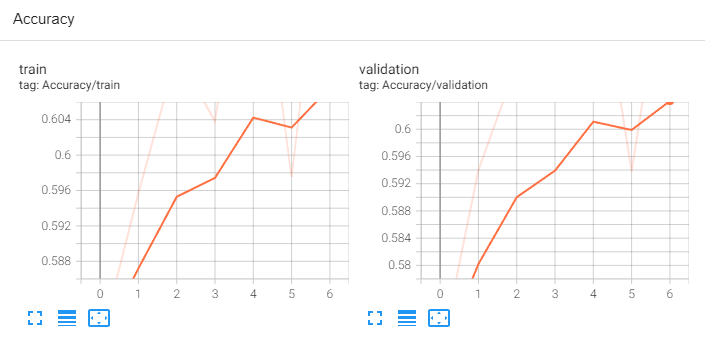

In [173]:
from IPython.display import Image
Image(filename="./BERT Accuracies.png")

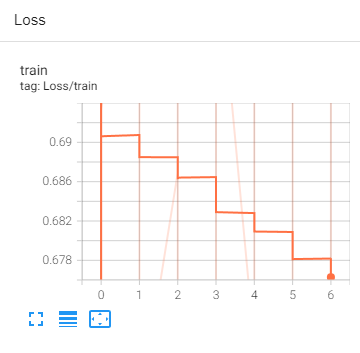

In [174]:
Image(filename="./BERT Loss.png")

In [153]:
tester(test_loader, parameters['device'])

Test Accuracy: 0.6319


* TODO: Have it run for 12 epochs or something